### 心理认知偏差
对交易有影响的交易偏差  
- 损失厌恶：对避免损失有一种强烈的偏好，不赔钱远比赚钱重要。
- 沉没成本效应：更重视已经花掉的钱，而不是未来可能要花的钱。
- 处置效应：早早兑现利润，却仍损失持续下去。
- 结果偏好：只会根据一个决策的结果来判断它的好坏，而不去考虑决策本身的质量。
- 近期偏好：更重视近期的数据或经验，忽视早期的数据或经验。
- 锚定效应：过于依赖容易获得的信息。
- 潮流效应：盲目相信一件事，只因为其他许多人都相信他。
- 信奉小数法则：从太少的信息中得出没有一句的结论。

## 海龟系统简介
海龟交易系统是一个完整的交易系统,它有一个完整的交易系统所应该有的所有成分，涵盖了成功交易中的每一个必要决策：
- 市场：买卖什么？
- 头寸规模：买卖多少？
- 入市：什么时候买卖？
- 止损：什么时候放弃一个亏损的头寸？
- 退出：什么时候退出一个盈利的头寸？
- 战术：怎么买卖？

“海龟们从不去预测市场的动向，而是会寻找市场处于某种特定状态的指示信号。优秀的交易者不会试着预测市场下一步会怎么样；相反，他们会观察指示信号，判断市场现在正处于什么样的状态中。”

### 趋势捕捉

唐奇安通道：当价格冲破上轨是可能的买入信号，反之，冲破下轨时是可能的卖出信号。  
上线=MAX(最高价,n)  
下线=MIN(最低价,n)  
中线=(上线+下线)/2

海龟交易的具体规则是：  

- 当今天的收盘价，大于过去20个交易日中的最高价时，以收盘价买入；  
- 买入后，当收盘价小于过去10个交易日中的最低价时，以收盘价卖出。

海龟交易系统本质上是一个趋势跟随的系统，但是最值得我们学习的，是资金管理尤其是分批建仓及动态止损的部分。

N值：仓位管理的核心，涉及加仓及止损。N值与技术指标平均真实波幅 ATR很相似。  
真实波幅： 真实波幅是以下三个值中的最大值  
1、当前交易日最高价和最低价的波幅 2、前一交易日的收盘价与当前交易日最高价的波幅 3、前一交易日的收盘价与当前交易日最低价的波幅
用公式写就是：TrueRange=Max(High−Low,abs(High−PreClose),abs(PreClose−Low))

N值计算公式为：

N=（PreN[−19：]+TrueRange）/20
其中 preN为前面N值，TrueRange为当前的真实波幅,此公式的真是含义为计算之前20天（包括今天在内）的N的平均值。  
有些海龟交易系统用的是ATR来代替N值，ATR为真实波幅的20日平均

### 买卖单位及首次建仓
Unit=（1%∗Account）/N  
首次建仓的时候，当捕捉到趋势，即价格突破唐奇安上轨时，买入1个unit。
其意义就是，让一个N值的波动与你总资金1%的波动对应，如果买入1unit单位的资产，当天震幅使得总资产的变化不超过1%。  
例如：
现在你有10万元资金，1%波动就是1000元。假如标X的N值为0.2元，1000元÷0.2元=5000股。也就是说，你的第一笔仓位应该是在其突破上轨（假设为5元）时立刻买入5000股，耗资25000元。

### 动态止损
当价格比最后一次买入价格下跌2N时，则卖出全部头寸止损。
接上面的例子，最后一次加仓价格为5.2。假如此时N值0.2元。 当价格下跌到$ 5.2 - 2*0.2 = 4.8$元时，清仓。 持仓成本为 （5+5.1+5.2）*5000/15000 = 5.1元。 此时亏损 （5.1-4.8）*15000 = 4500元 对于10万来说 这波亏损4.5%  

### 止盈

当股价跌破10日唐奇安通道下沿，清空头寸结束本次交易。

原始的海龟交易采用唐奇安通道来捕捉趋势，虽然能捕捉到大趋势，但是在震荡的情况下表现不如人意，不过这也是所有趋势型策略的通病。但是回测小的特点可以应用在资金管理上，择时可以看看多因子、动量反转等。

## 海龟交易规则Python实现代码

In [1]:
#先引入后面可能用到的包（package）
import pandas as pd  
import numpy as np
import talib as ta
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [2]:
#使用tushare获取交易数据
#设置token
import tushare as ts 
token='e0eeb08befd1f07516df2cbf9cbd58663f77fd72f92a04f290291c9d'
pro=ts.pro_api(token)
index={'上证综指': '000001.SH',
        '深证成指': '399001.SZ',
        '沪深300': '000300.SH',
        '创业板指': '399006.SZ',
        '上证50': '000016.SH',
        '中证500': '000905.SH',
        '中小板指': '399005.SZ',
        '上证180': '000010.SH'}

#获取当前交易的股票代码和名称
def get_code():
    df = pro.stock_basic(exchange='', list_status='L')
    codes=df.ts_code.values
    names=df.name.values
    stock=dict(zip(names,codes))
    #合并指数和个股成一个字典
    stocks=dict(stock,**index)
    return stocks    

#获取行情数据
def get_daily_data(stock,start,end):
    #如果代码在字典index里，则取的是指数数据
    code=get_code()[stock]
    if code in index.values():
        df=pro.index_daily(ts_code=code,start_date=start, end_date=end)
    #否则取的是个股数据
    else:
        df=pro.daily(ts_code=code, adj='qfq',start_date=start, end_date=end)
    #将交易日期设置为索引值
    df.index=pd.to_datetime(df.trade_date)
    df=df.sort_index()
    #计算收益率
    df['ret']=df.close/df.close.shift(1)-1
    return df

In [3]:
hs=get_daily_data('沪深300','20180101','')[['close','open','high','low','vol']]
#最近N1个交易日最高价
hs['up']=ta.MAX(hs.high,timeperiod=20).shift(1)
#最近N2个交易日最低价
hs['down']=ta.MIN(hs.low,timeperiod=10).shift(1)
#每日真实波动幅度
hs['ATR']=ta.ATR(hs.high,hs.low,hs.close,timeperiod=20)
hs.tail()

,close,open,high,low,vol,up,down,ATR
trade_date,,,,,,,,
2019-09-30,3814.5282,3842.0741,3857.2319,3813.5491,65931313.0,3985.239,3832.2466,45.694704
2019-10-08,3837.6791,3818.5894,3861.6429,3818.5894,76657860.0,3985.239,3813.5491,45.765703
2019-10-09,3843.2392,3822.6068,3845.3403,3805.0671,75854512.0,3985.239,3813.5491,45.491078
2019-10-10,3874.6391,3838.4865,3877.1420,3829.4328,79222694.0,3985.239,3805.0671,45.601984
2019-10-11,3911.7253,3885.5198,3922.3694,3868.8417,93412577.0,3985.239,3805.0671,45.998270


In [4]:
def my_strategy(data):
    x1=data.close>data.up
    x2=data.close.shift(1)<data.up.shift(1)
    x=x1&x2
    y1=data.close<data.down
    y2=data.close.shift(1)>data.down.shift(1)
    y=y1&y2
    data.loc[x,'signal']='buy'
    data.loc[y,'signal']='sell'
    buy_date=(data[data.signal=='buy'].index).strftime('%Y%m%d')
    sell_date=(data[data.signal=='sell'].index).strftime('%Y%m%d')
    buy_close=data[data.signal=='buy'].close.round(2).tolist()
    sell_close=data[data.signal=='sell'].close.round(2).tolist()
    return (buy_date,buy_close,sell_date,sell_close)

In [5]:
#对K线图和唐奇安通道进行可视化
from pyecharts import *
grid = Grid()
attr=[str(t) for t in hs.index.strftime('%Y%m%d')]

v1=np.array(hs.loc[:,['open','close','low','high']])
v2=np.array(hs.up)
v3=np.array(hs.down)

kline = Kline("沪深300唐奇安通道",title_text_size=15)
kline.add("K线图", attr, v1.round(1),is_datazoom_show=True,)
# 成交量
bar = Bar()
bar.add("成交量", attr, hs['vol'],tooltip_tragger="axis", is_legend_show=False, 
        is_yaxis_show=False, yaxis_max=5*max(hs["vol"]))

line = Line()
line.add("上轨线", attr, v2.round(1),is_datazoom_show=True,
         is_smooth=True,is_symbol_show=False,line_width=1.5)
line.add("下轨线", attr, v3.round(1),is_datazoom_show=True,
         is_smooth=True,is_symbol_show=False,line_width=1.5)

#添加买卖信号
bd,bc,sd,sc=my_strategy(hs)
es = EffectScatter("buy")
es.add( "sell", sd, sc, )
es.add("buy", bd, bc,symbol="triangle",)
    
overlap = Overlap(width=2000, height=600)
overlap.add(kline)
overlap.add(line)
overlap.add(bar,yaxis_index=1, is_add_yaxis=True)
overlap.add(es)

grid.add(overlap, grid_right="10%")
grid

In [6]:
#关掉pandas的warnings
pd.options.mode.chained_assignment = None
def strategy(stock,start,end,N1=20,N2=10):
    df=get_daily_data(stock,start,end)
    #最近N1个交易日最高价
    df['H_N1']=ta.MAX(df.high,timeperiod=N1)
    #最近N2个交易日最低价
    df['L_N2']=ta.MIN(df.low,timeperiod=N2)
    
    #当日收盘价>昨天最近N1个交易日最高点时发出信号设置为1
    buy_index=df[df.close>df['H_N1'].shift(1)].index
    df.loc[buy_index,'收盘信号']=1
    #将当日收盘价<昨天最近N2个交易日的最低点时收盘信号设置为0
    sell_index=df[df.close<df['L_N2'].shift(1)].index
    df.loc[sell_index,'收盘信号']=0
    df['当天仓位']=df['收盘信号'].shift(1)
    df['当天仓位'].fillna(method='ffill',inplace=True)
    d=df[df['当天仓位']==1].index[0]-timedelta(days=1)
    df1=df.loc[d:].copy()
    df1['ret'][0]=0
    df1['当天仓位'][0]=0
    #当仓位为1时，买入持仓，当仓位为0时，空仓，计算资金净值
    df1['策略净值']=(df1.ret.values*df1['当天仓位'].values+1.0).cumprod()
    df1['指数净值']=(df1.ret.values+1.0).cumprod()
    df1['策略收益率']=df1['策略净值']/df1['策略净值'].shift(1)-1
    df1['指数收益率']=df1.ret
    total_ret=df1[['策略净值','指数净值']].iloc[-1]-1
    annual_ret=pow(1+total_ret,250/len(df1))-1
    dd=(df1[['策略净值','指数净值']].cummax()-df1[['策略净值','指数净值']])/df1[['策略净值','指数净值']].cummax()
    d=dd.max()
    beta=df1[['策略收益率','指数收益率']].cov().iat[0,1]/df1['指数收益率'].var()
    alpha=(annual_ret['策略净值']-annual_ret['指数净值']*beta)
    exReturn=df1['策略收益率']-0.03/250
    sharper_atio=np.sqrt(len(exReturn))*exReturn.mean()/exReturn.std()
    TA1=round(total_ret['策略净值']*100,2)
    TA2=round(total_ret['指数净值']*100,2)
    AR1=round(annual_ret['策略净值']*100,2)
    AR2=round(annual_ret['指数净值']*100,2)
    MD1=round(d['策略净值']*100,2)
    MD2=round(d['指数净值']*100,2)
    S=round(sharper_atio,2)
    df1[['策略净值','指数净值']].plot(figsize=(15,7))
    plt.title(stock+'海龟交易策略简单回测',size=15)
    bbox = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    plt.text(df1.index[int(len(df1)/5)], df1['指数净值'].max()/1.5, f'累计收益率：\
策略{TA1}%，指数{TA2}%;\n年化收益率：策略{AR1}%，指数{AR2}%；\n最大回撤：  策略{MD1}%，指数{MD2}%;\n\
策略alpha: {round(alpha,2)}，策略beta：{round(beta,2)}; \n夏普比率：  {S}',size=13,bbox=bbox)  
    plt.xlabel('')
    ax=plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    plt.show()
    #return df1.loc[:,['close','ret','H_N1','L_N2','当天仓位','策略净值','指数净值']]

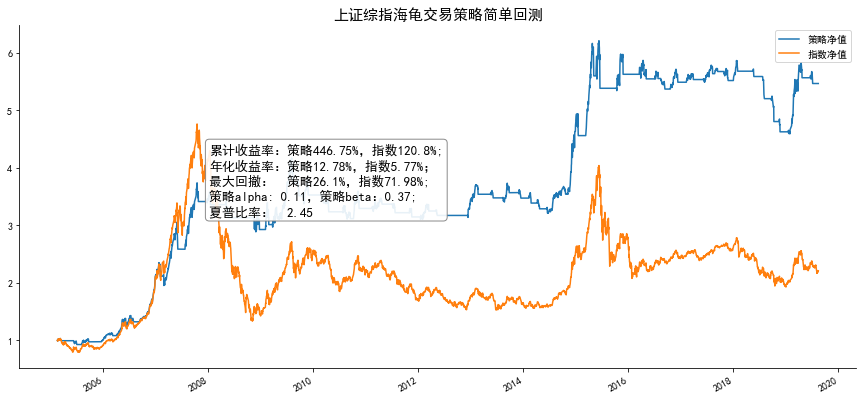

In [7]:
strategy('上证综指','20050101','')

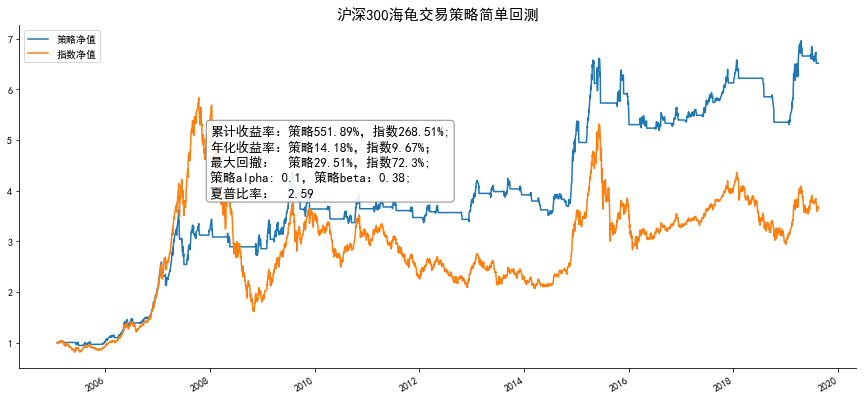

In [8]:
strategy('沪深300','','')

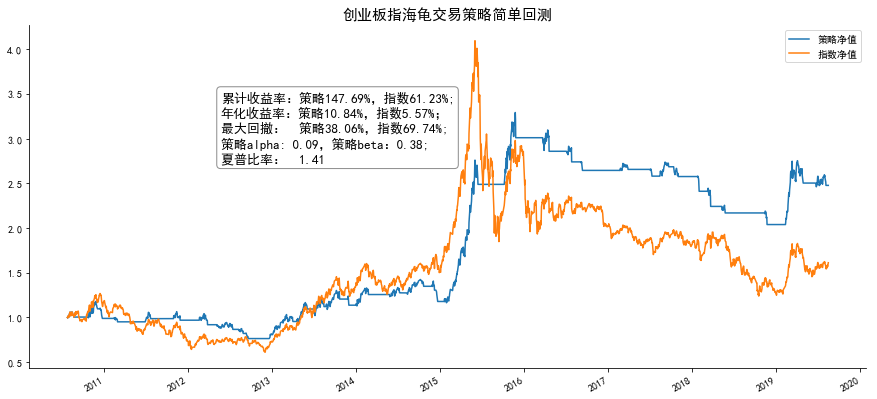

In [9]:
strategy('创业板指','','')

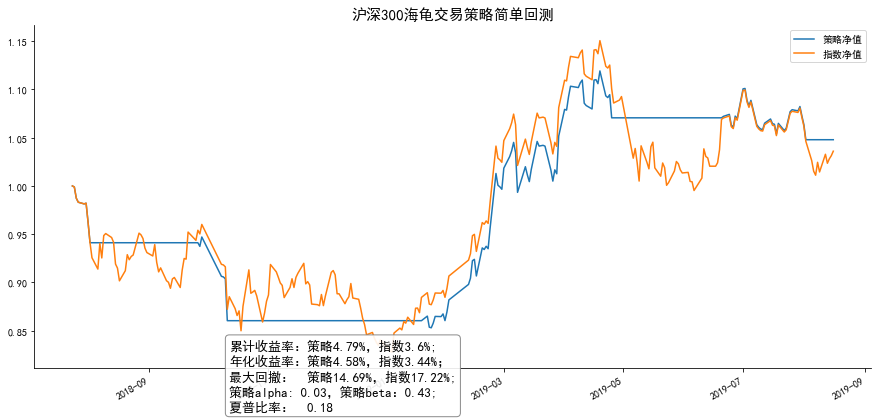

In [10]:
strategy('沪深300','20180101','')

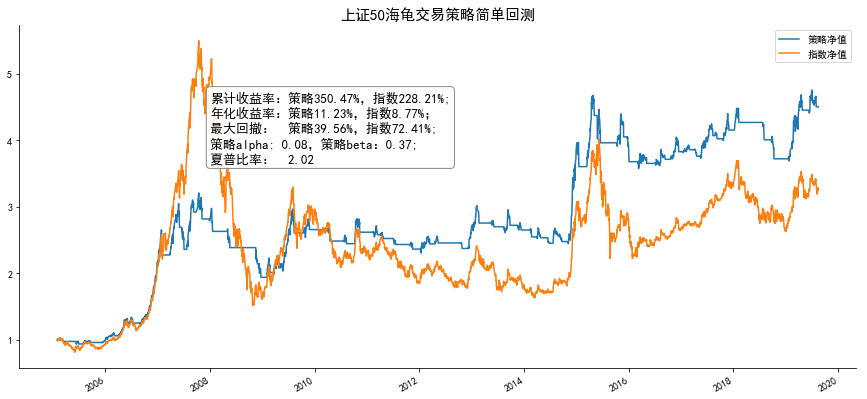

In [11]:
strategy('上证50','20050101','',N1=20,N2=10)

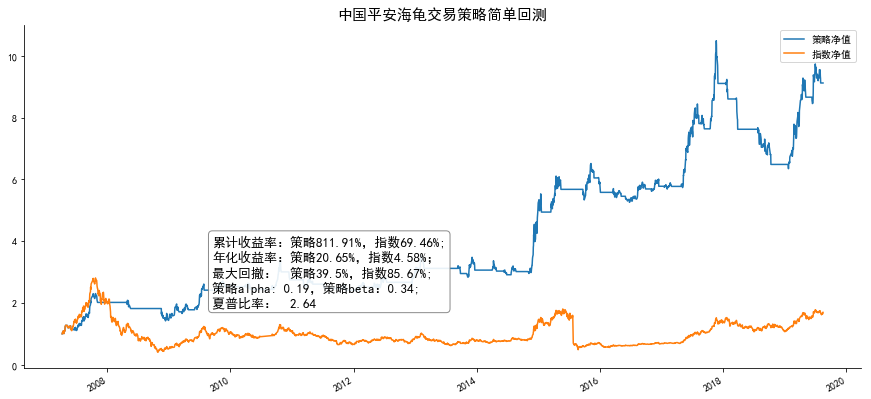

In [12]:
strategy('中国平安','20050101','',N1=20,N2=10)

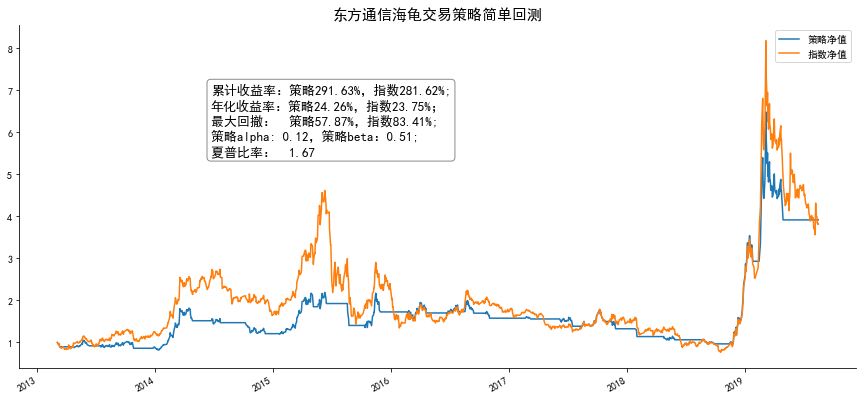

In [13]:
strategy('东方通信','20130101','',N1=20,N2=10)

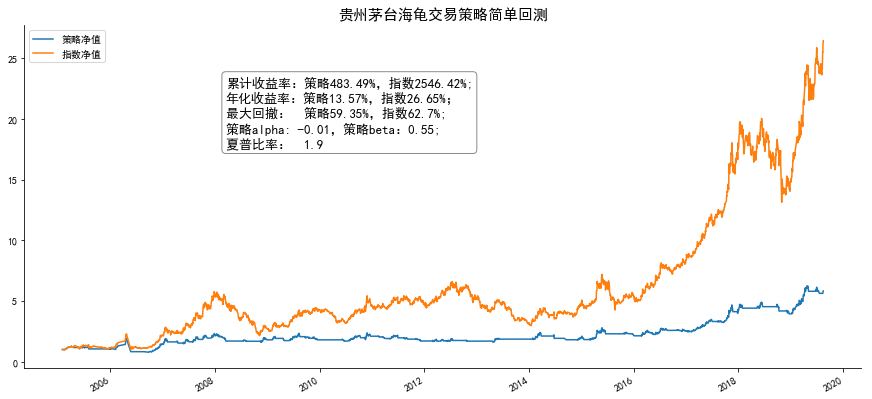

In [14]:
strategy('贵州茅台','20050101','',N1=20,N2=10)

In [15]:
df=get_daily_data('沪深300','20130101','')[['close','open','high','low','pre_close','pct_chg']]
df.head()

,close,open,high,low,pre_close,pct_chg
trade_date,,,,,,
2013-01-04,2524.409,2551.814,2558.529,2498.892,2522.952,0.0577
2013-01-07,2535.985,2518.047,2545.969,2511.603,2524.409,0.4586
2013-01-08,2525.330,2534.647,2540.513,2502.490,2535.985,-0.4202
2013-01-09,2526.126,2518.104,2534.239,2504.299,2525.330,0.0315
2013-01-10,2530.569,2525.590,2553.352,2513.729,2526.126,0.1759


In [16]:
#计算ATR和unit
Total_value=100000
#最近N1个交易日最高价
df['up']=ta.MAX(df.high,timeperiod=20).shift(1)
#最近N2个交易日最低价
df['down']=ta.MIN(df.low,timeperiod=10).shift(1)
#每日真实波动幅度
df['ATR']=ta.ATR(df.high,df.low,df.close,timeperiod=20)

In [17]:
def buy_sell_signal(data):
    x1=data.close>data.up
    x2=data.close.shift(1)<data.up.shift(1)
    x=x1&x2
    y1=data.close<data.down
    y2=data.close.shift(1)>data.down.shift(1)
    y=y1&y2
    data['signal']=0
    data.loc[x,'signal']=1
    data.loc[y,'signal']=-1
    return data

In [18]:
df1=buy_sell_signal(df)
df1.head()

,close,open,high,low,pre_close,pct_chg,up,down,ATR,signal
trade_date,,,,,,,,,,
2013-01-04,2524.409,2551.814,2558.529,2498.892,2522.952,0.0577,NaN,NaN,NaN,0
2013-01-07,2535.985,2518.047,2545.969,2511.603,2524.409,0.4586,NaN,NaN,NaN,0
2013-01-08,2525.330,2534.647,2540.513,2502.490,2535.985,-0.4202,NaN,NaN,NaN,0
2013-01-09,2526.126,2518.104,2534.239,2504.299,2525.330,0.0315,NaN,NaN,NaN,0
2013-01-10,2530.569,2525.590,2553.352,2513.729,2526.126,0.1759,NaN,NaN,NaN,0


In [19]:
d=df1[df1.signal==1].index[0]
df2=df1.loc[d:]
df2.head()

,close,open,high,low,pre_close,pct_chg,up,down,ATR,signal
trade_date,,,,,,,,,,
2013-05-08,2542.798,2542.266,2562.007,2531.251,2529.938,0.5083,2542.453,2423.077,46.657343,1
2013-05-09,2527.794,2542.374,2543.305,2507.792,2542.798,-0.5901,2562.007,2423.077,46.100126,0
2013-05-10,2540.836,2519.517,2546.975,2515.158,2527.794,0.5159,2562.007,2423.077,45.385970,0
2013-05-13,2530.768,2542.412,2547.602,2516.728,2540.836,-0.3962,2562.007,2423.077,44.660371,0
2013-05-14,2493.338,2525.998,2526.145,2479.872,2530.768,-1.4790,2562.007,2423.077,44.972153,0


In [20]:
df2['初始总头寸']=1000000
df2.head()

,close,open,high,low,pre_close,pct_chg,up,down,ATR,signal,初始总头寸
trade_date,,,,,,,,,,,
2013-05-08,2542.798,2542.266,2562.007,2531.251,2529.938,0.5083,2542.453,2423.077,46.657343,1,1000000
2013-05-09,2527.794,2542.374,2543.305,2507.792,2542.798,-0.5901,2562.007,2423.077,46.100126,0,1000000
2013-05-10,2540.836,2519.517,2546.975,2515.158,2527.794,0.5159,2562.007,2423.077,45.385970,0,1000000
2013-05-13,2530.768,2542.412,2547.602,2516.728,2540.836,-0.3962,2562.007,2423.077,44.660371,0,1000000
2013-05-14,2493.338,2525.998,2526.145,2479.872,2530.768,-1.4790,2562.007,2423.077,44.972153,0,1000000


In [ ]:
d=df[df['当天仓位']==1].index[0]-timedelta(days=1)
df1=df.loc[d:].copy()
df1['ret'][0]=0
df1['当天仓位'][0]=0

In [14]:
def IN_OR_OUT(data,price,T):
    up = max(data['highPrice'].iloc[-T:-1])
    down = min(data['lowPrice'].iloc[-int(T/2):-1])  # 这里是10日唐奇安下沿
    if price>up:
        return 1
    elif price<down:
        return -1
    else:
        return 0 


def Add_OR_Stop(price,lastprice,ATR):
    if price >= lastprice + 0.5*ATR:
        return 1
    elif price <= lastprice - 2*ATR:
        return -1
    else:
        return 0

In [15]:
hs.tail()

,close,open,high,low,vol,up,down,ATR,signal
trade_date,,,,,,,,,
2019-07-09,3793.1297,3798.0954,3811.0993,3774.7641,74842732.0,3942.4257,3755.0099,63.421641,NaN
2019-07-10,3786.7390,3807.9497,3810.3960,3774.2304,72833948.0,3942.4257,3771.7164,62.058839,NaN
2019-07-11,3785.2210,3806.1855,3830.7387,3774.4137,75311965.0,3942.4257,3774.2304,61.772147,NaN
2019-07-12,3808.7311,3783.0733,3820.2354,3774.5224,75465967.0,3942.4257,3774.2304,60.969190,NaN
2019-07-15,3824.1878,3792.6409,3844.8683,3745.8549,101205222.0,3942.4257,3774.2304,62.871400,NaN


In [ ]:
def handle_data(context): 
    T = 20
    data = pd.DataFrame(data)
    prices = context.current_price(stk) #获得最近价格
    today = Date.fromDateTime(context.current_date) 
    today = today.toISO() #转换为标准日期格式

    #剔除停牌的股票
    if np.isnan(prices) or prices == 0:  # 停牌或是还没有上市等原因不能交易
        return 

    # 计算ATR和unit
    ATR = CalcATR(data)
    value = stock_account.portfolio_value * 0.01
    context.unit = CalcUnit(value,ATR)

    #判断是否处于空仓的状态
    if SellComplete(context.hold_flag,stock_account.get_positions()): 
        for stk in stock_account.get_positions():
            stock_account.order_to(stk,0)

    #判断买卖时机
    out = IN_OR_OUT(data,prices,T)
    if out ==1 and context.hold_flag==False:  
        stock_account.order_to(stk,context.unit)
        context.add_time = 1 #入场之后持仓就+1
        context.hold_flag = True
        context.last_buy_prcie = prices             
    elif out==-1 and context.hold_flag ==True: #离场
        stock_account.order_to(stk,0)
        initialize(context)   # 重新初始化参数
     
    #判断加仓或止损
    if context.hold_flag==True and len(stock_account.get_positions())>0:   
        temp = Add_OR_Stop(prices,context.last_buy_prcie,ATR)
        if temp ==1 and context.add_time<=context.limit_unit:  # 加仓
            order_num = min(context.unit,int((stock_account.cash/prices)/100)*100)      
            stock_account.order(stk,order_num)
            context.last_buy_prcie = prices
            context.add_time += 1
        elif temp== -1:      # 止损
            stock_account.order_to(stk,0)
            initialize(context)  

    return